# 1 LOAD LIBRARY

In [322]:
# Xử lý thời gian và dữ liệu
from datetime import datetime
import pandas as pd
import numpy as np

# Thống kê và phân tích
import random
from scipy.stats import (chi2, chi2_contingency, zscore, ttest_1samp, ttest_ind, levene, kstest, mannwhitneyu, ttest_rel, norm, rankdata, kruskal, pearsonr, spearmanr)
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder

# Vẽ biểu đồ
import matplotlib.pyplot as plt
import seaborn as sns

# Làm việc với Google Sheets
import gspread
from gspread_dataframe import set_with_dataframe
from google.oauth2.service_account import Credentials
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import drive
drive.mount('/content/drive')
from google.auth import default
from google.colab import auth

# Cài đặt hiển thị rộng hơn cho DataFrame
pd.set_option('display.width', 1000)  # Độ rộng tối đa
pd.set_option('display.max_columns', None)  # Hiển thị tất cả các cột
pd.set_option('display.max_rows', None)  # Hiển thị tất cả các hàng

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2 READ DATA
About Dataset:
The data is a subset of the Taxi Trips (the City of Chicago Taxi Trips) data, and focuses on a two-day period in May of 2022.

In [323]:
# File path to your file
chicago_taxi_dataset = "/content/drive/My Drive/Colab Notebooks/Data/chicago_taxi_train.csv"

# Read the SPSS file
df_full = pd.read_csv(chicago_taxi_dataset)
df = df_full[['TRIP_MILES', 'TRIP_SECONDS', 'FARE', 'COMPANY', 'PAYMENT_TYPE', 'TIP_RATE']]

In [324]:
df = df.rename(columns={'TRIP_MILES': 'trip_miles'})
df = df.rename(columns={'TRIP_SECONDS': 'trip_seconds'})
df = df.rename(columns={'FARE': 'fare'})
df = df.rename(columns={'COMPANY': 'company'})
df = df.rename(columns={'PAYMENT_TYPE': 'payment_type'})
df = df.rename(columns={'TIP_RATE': 'tip_rate'})

print(df.columns)

Index(['trip_miles', 'trip_seconds', 'fare', 'company', 'payment_type', 'tip_rate'], dtype='object')


# 3 DATA WRANGLING

In [325]:
# Encoding Categorical Columns
df_encoding = df.copy()

In [326]:
categorical_columns=df_encoding.select_dtypes(include='object').columns
encoder = LabelEncoder()
for col in categorical_columns:
    # df_encoding[col]=encoder.fit_transform(df_encoding[col])

    # Fit encoder trước khi transform
    encoder.fit(df_encoding[col])

    # Tạo DataFrame mapping
    # mapping_df = pd.DataFrame({'Original': encoder.classes_, 'Encoded': range(len(encoder.classes_))})

    # Tạo DataFrame mapping với tên bảng riêng
    mapping_df = pd.DataFrame({'Original': encoder.classes_, 'Encoded': range(len(encoder.classes_))})
    mapping_df_name = f"mapping_{col}" # tạo tên bảng mapping dựa trên tên cột
    globals()[mapping_df_name] = mapping_df # lưu bảng mapping vào biến toàn cục

    # Áp dụng transform
    df_encoding[col] = encoder.transform(df_encoding[col])

    print(f"\nBảng mapping cho cột {col}:")
    print(globals()[mapping_df_name]) # in bảng mapping từ biến toàn cục


Bảng mapping cho cột company:
                                Original  Encoded
0                          24 Seven Taxi        0
1                2733 - 74600 Benny Jona        1
2          312 Medallion Management Corp        2
3            3556 - 36214 RC Andrews Cab        3
4           4053 - 40193 Adwar H. Nikola        4
5                   4623 - 27290 Jay Kim        5
6               4787 - 56058 Reny Cab Co        6
7            6574 - Babylon Express Inc.        7
8           Blue Ribbon Taxi Association        8
9      Blue Ribbon Taxi Association Inc.        9
10                  Chicago Independents       10
11                       Chicago Taxicab       11
12               Choice Taxi Association       12
13                          City Service       13
14                             Flash Cab       14
15                            Globe Taxi       15
16                 KOAM Taxi Association       16
17                 Koam Taxi Association       17
18                 

In [327]:
df_encoding.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31694 entries, 0 to 31693
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   trip_miles    31694 non-null  float64
 1   trip_seconds  31694 non-null  int64  
 2   fare          31694 non-null  float64
 3   company       31694 non-null  int64  
 4   payment_type  31694 non-null  int64  
 5   tip_rate      31694 non-null  float64
dtypes: float64(3), int64(3)
memory usage: 1.5 MB


In [328]:
print(df_encoding.head())

   trip_miles  trip_seconds   fare  company  payment_type  tip_rate
0        2.57          2341  31.99       14             3       6.3
1        1.18          1074   9.75       14             1      27.9
2        1.29          1173  10.25       24             0       0.0
3        3.70          3360  23.75       12             0       0.0
4        1.15          1044  10.00       14             0       0.0


# 4 EXPLORE DATA ANALYSIS

In [329]:
df.head()

,trip_miles,trip_seconds,fare,company,payment_type,tip_rate
0,2.57,2341,31.99,Flash Cab,Mobile,6.3
1,1.18,1074,9.75,Flash Cab,Credit Card,27.9
2,1.29,1173,10.25,Sun Taxi,Cash,0.0
3,3.70,3360,23.75,Choice Taxi Association,Cash,0.0
4,1.15,1044,10.00,Flash Cab,Cash,0.0


In [330]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31694 entries, 0 to 31693
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   trip_miles    31694 non-null  float64
 1   trip_seconds  31694 non-null  int64  
 2   fare          31694 non-null  float64
 3   company       31694 non-null  object 
 4   payment_type  31694 non-null  object 
 5   tip_rate      31694 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 1.5+ MB


In [331]:
df.describe()

,trip_miles,trip_seconds,fare,tip_rate
count,31694.000000,31694.000000,31694.000000,31694.000000
mean,8.289463,1319.796397,23.905210,12.965785
std,7.265672,928.932873,16.970022,15.517765
min,0.500000,60.000000,3.250000,0.000000
25%,1.720000,548.000000,9.000000,0.000000
50%,5.920000,1081.000000,18.750000,12.200000
75%,14.500000,1888.000000,38.750000,20.800000
max,68.120000,7140.000000,159.250000,648.600000


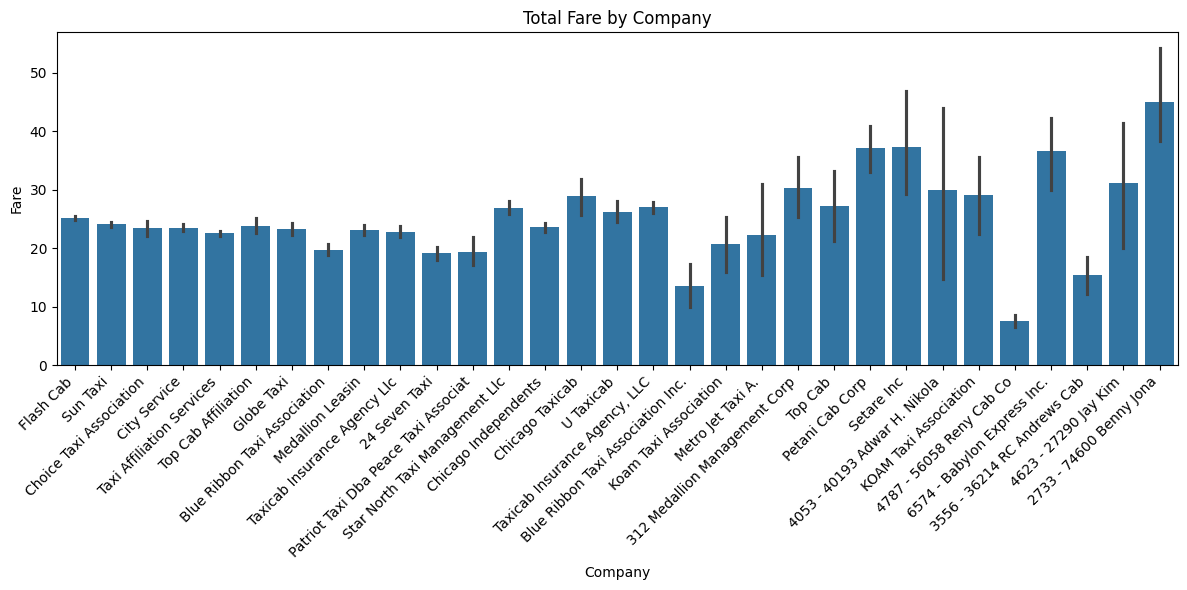


Number of companies: 31


Top 6 companies with the highest total fare:
company
Flash Cab                        197900.53
Taxi Affiliation Services         98395.50
Sun Taxi                          96756.38
City Service                      75058.67
Chicago Independents              42403.45
Taxicab Insurance Agency, LLC     36844.00
Name: fare, dtype: float64


In [332]:
plt.figure(figsize=(12, 6))
sns.barplot(x='company', y='fare', data=df)
plt.title('Total Fare by Company')
plt.xlabel('Company')
plt.ylabel('Fare')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()
print()

# Calculate the total fare for each company
company_fares = df.groupby('company')['fare'].sum()

# Number of unique companies
num_companies = len(company_fares)
print(f"Number of companies: {num_companies}")
print()

# Top 6 companies with the highest total fare
top_6_companies = company_fares.nlargest(6)
print("\nTop 6 companies with the highest total fare:")
print(top_6_companies)

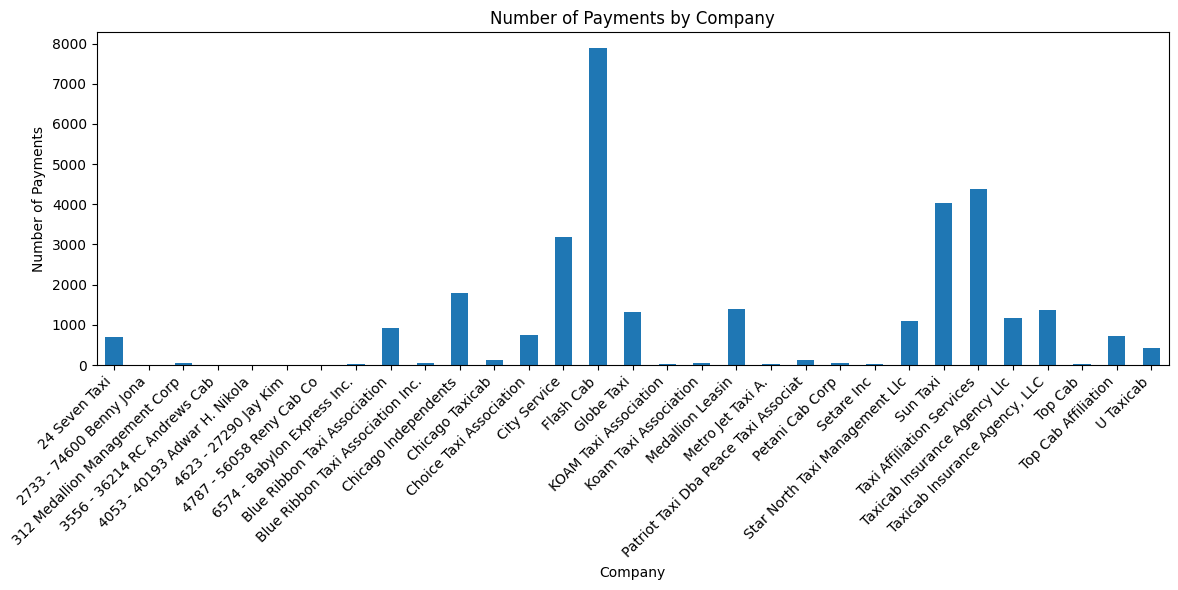



Top 6 companies with the highest number of payments:


,payment_type
company,
Flash Cab,7887
Taxi Affiliation Services,4371
Sun Taxi,4024
City Service,3199
Chicago Independents,1800
Medallion Leasin,1390


In [333]:
# Count the number of payments for each company
payment_counts = df.groupby('company')['payment_type'].count()

# Create the bar chart
plt.figure(figsize=(12, 6))
payment_counts.plot(kind='bar')
plt.title('Number of Payments by Company')
plt.xlabel('Company')
plt.ylabel('Number of Payments')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
print()

# Count the number of payments for each company
payment_counts = df.groupby('company')['payment_type'].count()

# Get the top 6 companies with the most payments
top_6_payment_companies = payment_counts.nlargest(6)

print("\nTop 6 companies with the highest number of payments:")
top_6_payment_companies

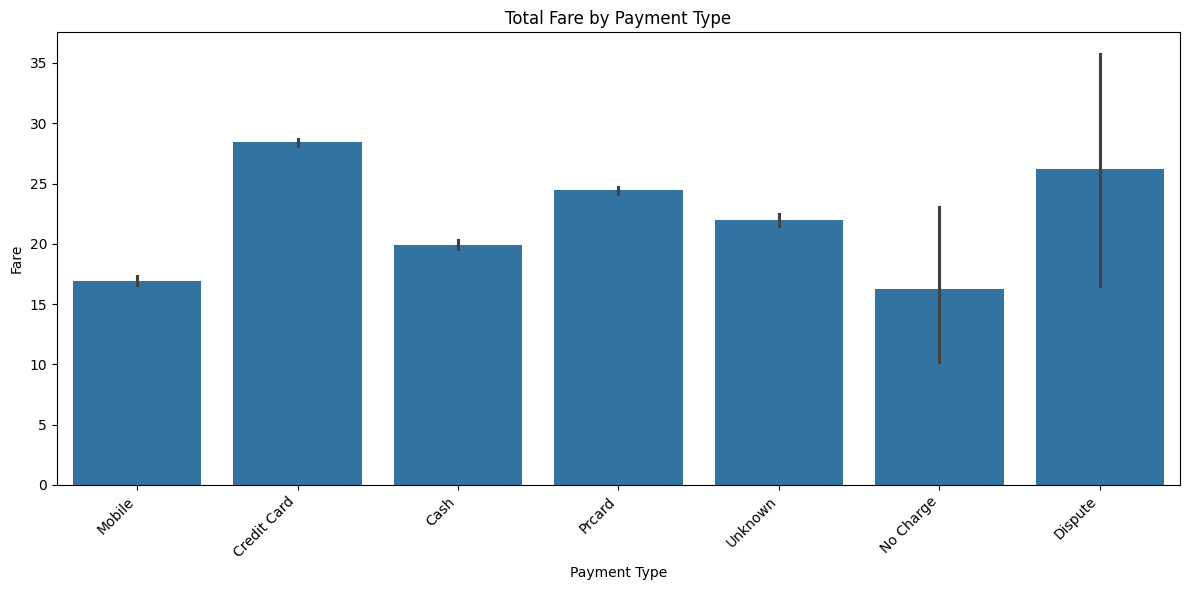


Number of Payment Type: 7


Top 7 companies with the highest total fare:
payment_type
Credit Card    401673.07
Cash           174785.78
Prcard          85667.00
Mobile          68399.87
Unknown         26473.25
Dispute           392.50
No Charge         260.25
Name: fare, dtype: float64


In [334]:
plt.figure(figsize=(12, 6))
sns.barplot(x='payment_type', y='fare', data=df)
plt.title('Total Fare by Payment Type')
plt.xlabel('Payment Type')
plt.ylabel('Fare')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()
print()

# Calculate the total fare for each company
payment_type_fares = df.groupby('payment_type')['fare'].sum()

# Number of unique companies
num_companies = len(payment_type_fares)
print(f"Number of Payment Type: {num_companies}")
print()

# Top 6 companies with the highest total fare
top_6_payment_type = payment_type_fares.nlargest(10)
print("\nTop 7 companies with the highest total fare:")
print(top_6_payment_type)

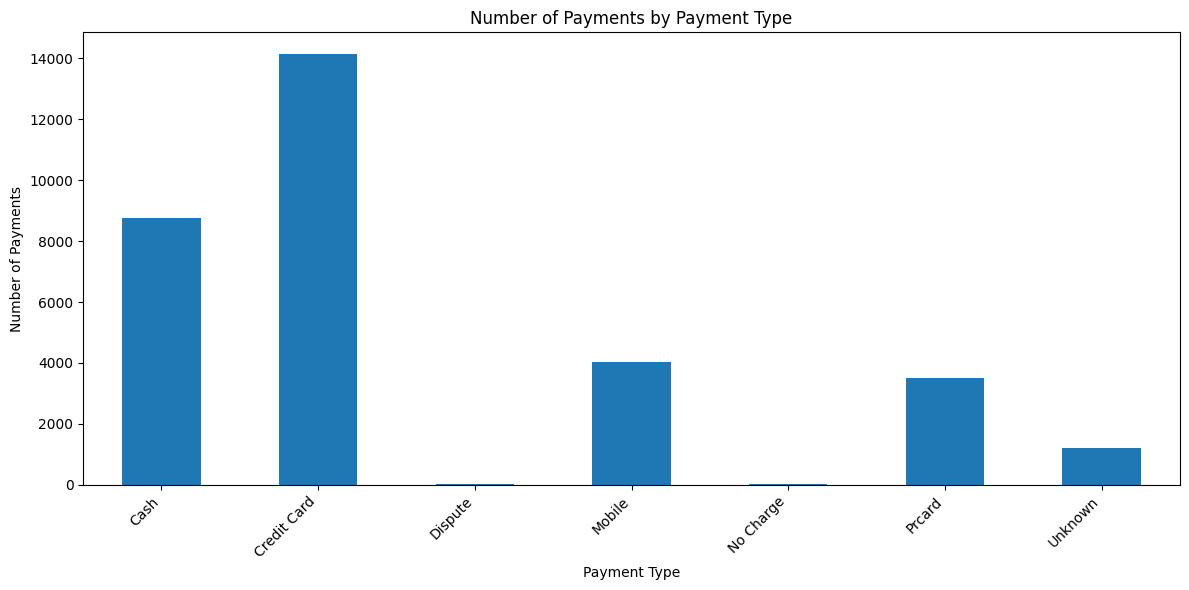



Top 7 Payment Type with the highest number of payments:


,payment_type
payment_type,
Credit Card,14142
Cash,8770
Mobile,4041
Prcard,3504
Unknown,1206
No Charge,16
Dispute,15


In [335]:
# Count the number of payments for each company
payment_counts = df.groupby('payment_type')['payment_type'].count()

# Create the bar chart
plt.figure(figsize=(12, 6))
payment_counts.plot(kind='bar')
plt.title('Number of Payments by Payment Type')
plt.xlabel('Payment Type')
plt.ylabel('Number of Payments')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
print()

# Count the number of payments for each company
payment_counts = df.groupby('payment_type')['payment_type'].count()

# Get the top 6 companies with the most payments
top_6_payment_payment_type = payment_counts.nlargest(7)

print("\nTop 7 Payment Type with the highest number of payments:")
top_6_payment_payment_type

# 4 FEATURE ENGINEERING



## 4.1 REMOVE OUTLIERS

In [336]:
# Hàm loại bỏ ngoại lai dùng IQR
def remove_outliers_iqr(df):
    df_clean = df.copy()
    numeric_cols = df.select_dtypes(include=['number']).columns
    selected_columns = ['trip_miles', 'trip_seconds', 'fare', 'tip_rate']  # Danh sách cột cần lấy
    for col in numeric_cols.intersection(selected_columns):  # Chỉ lấy những cột vừa là số, vừa có trong danh sách chọn
    # for col in df.select_dtypes(include=['number']).columns:  # Chỉ áp dụng cho cột số
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

training_data = remove_outliers_iqr(df_encoding)
print(training_data.info())

# Input the dependent variable
dependent_var = 'fare'
y = training_data[dependent_var]

# Define the independent variables
independent_vars = training_data.columns.drop([dependent_var]).tolist()
X = training_data[independent_vars]

# Define the confidence interval
confidence_interval = 0.95
z_value = norm.ppf((1 + confidence_interval) / 2)
alpha = round(1 - confidence_interval, 3)

<class 'pandas.core.frame.DataFrame'>
Index: 30669 entries, 0 to 31691
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   trip_miles    30669 non-null  float64
 1   trip_seconds  30669 non-null  int64  
 2   fare          30669 non-null  float64
 3   company       30669 non-null  int64  
 4   payment_type  30669 non-null  int64  
 5   tip_rate      30669 non-null  float64
dtypes: float64(3), int64(3)
memory usage: 1.6 MB
None


## 4.2 SCATTER PLOT FOR EACH INDEPENDENT VARIABLE

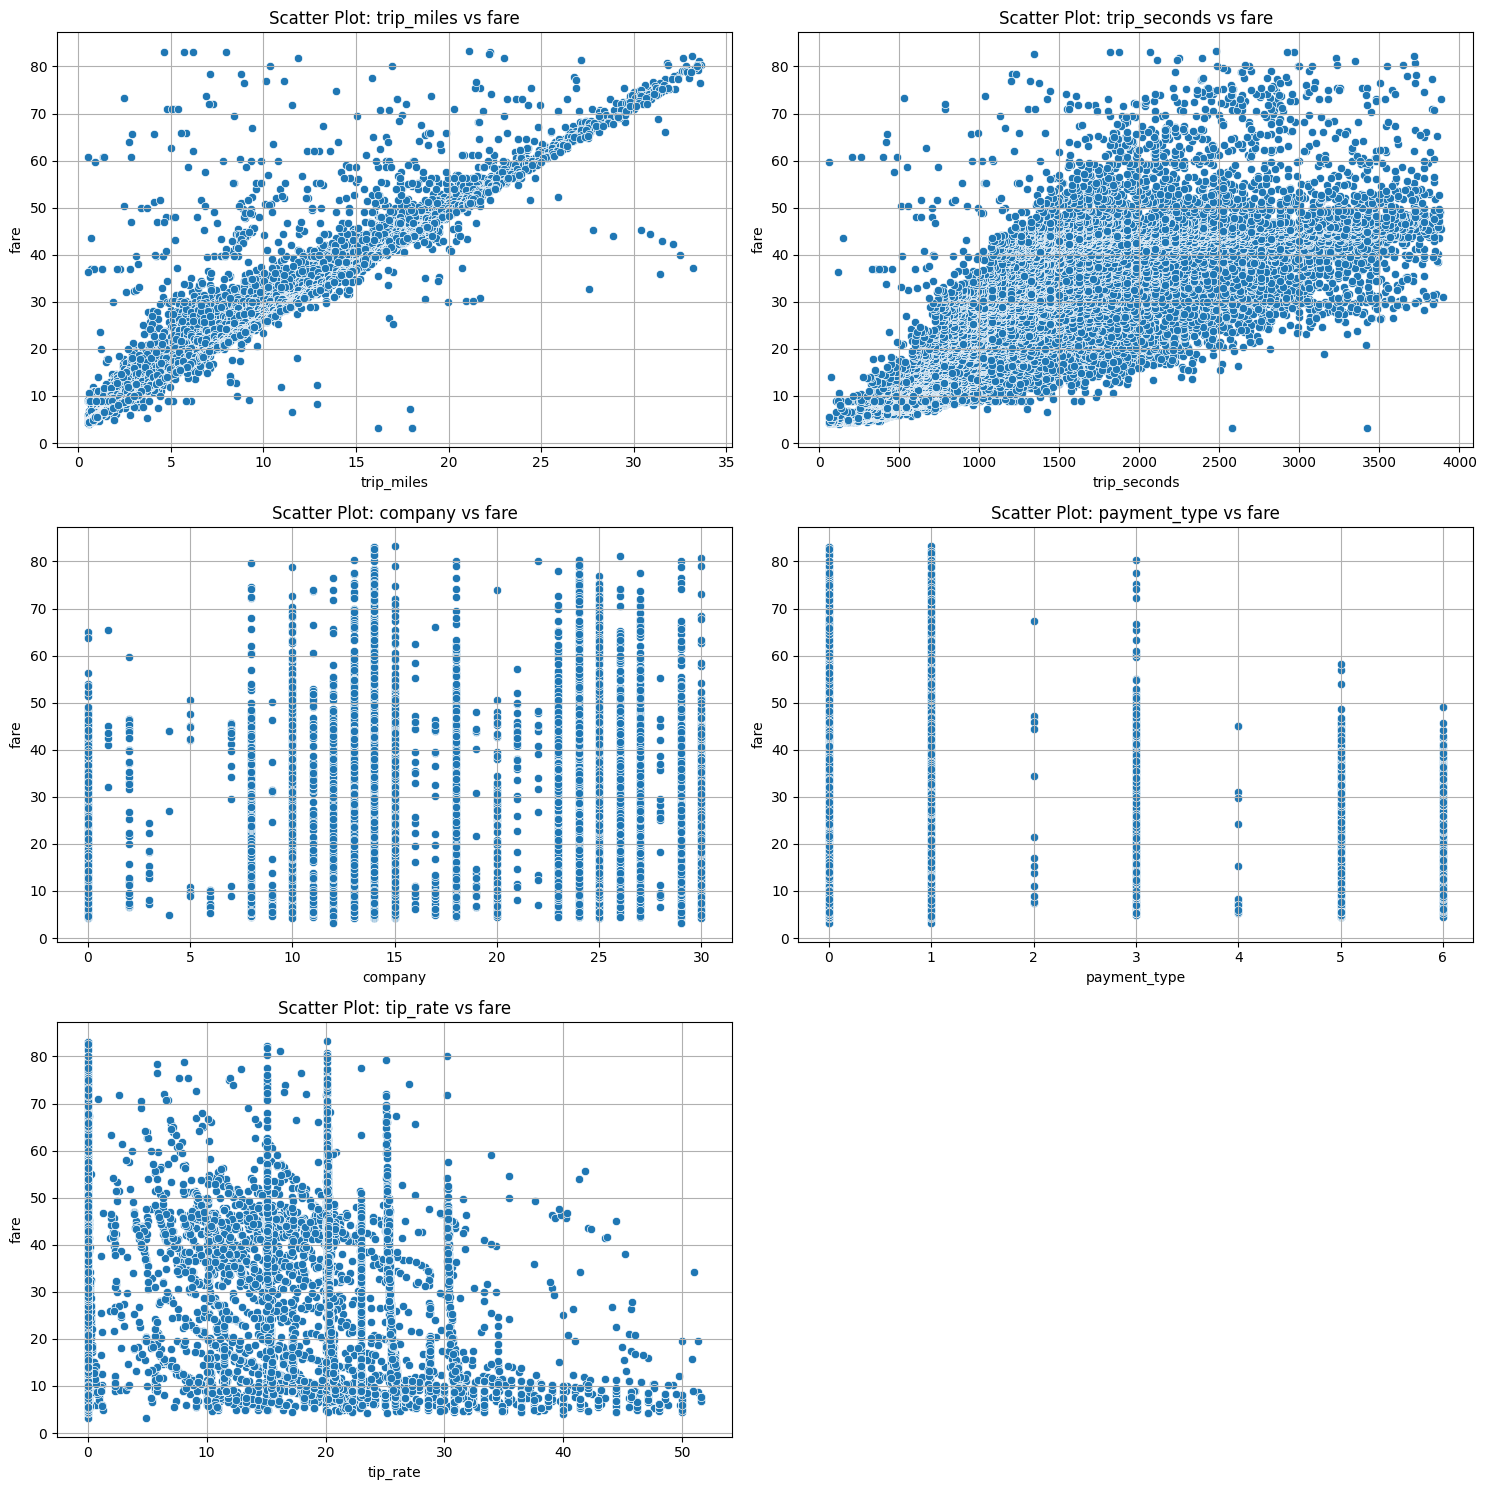

In [337]:
# Biểu đồ phân tán cho từng biến độc lập
num_plots = len(independent_vars)
cols = 2  # Number of columns in the subplot grid
rows = (num_plots + cols - 1) // cols  # Calculate the number of rows needed

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))  # Adjust figsize as needed
axes = axes.ravel()  # Flatten the axes array for easier iteration


for i, col in enumerate(independent_vars):
    sns.scatterplot(x=col, y=dependent_var, data=training_data, ax=axes[i])
    axes[i].set_title(f'Scatter Plot: {col} vs {dependent_var}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel(f'{dependent_var}')
    axes[i].grid(True)

# Hide any unused subplots
for j in range(i + 1, rows * cols):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust layout to prevent overlapping titles/labels
plt.show()

## 4.3. CORRELATION COEFFICIENT

<Axes: >

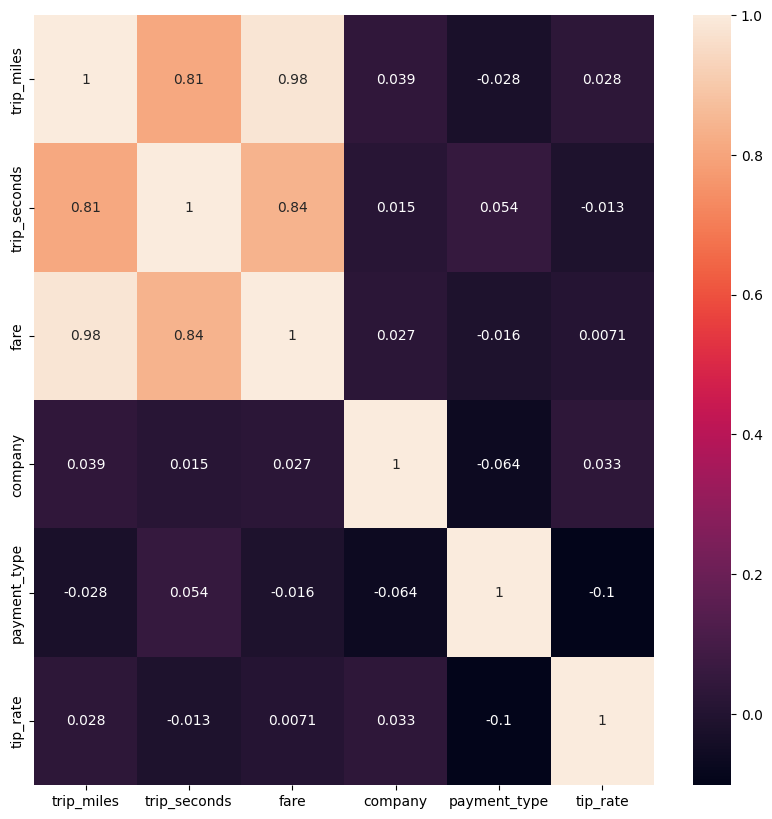

In [338]:
# Calculate the correlation matrix
correlation_matrix = training_data.corr()

#Correlation Heatmap (print the correlation score each variables)
plt.figure(figsize=(10, 10))
sns.heatmap(training_data.corr(), fmt='.2g', annot=True)

## 4.4 STEPWISE SELECTION

In [339]:
# Function to calculate VIF
def calculate_vif(X):
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    if X.shape[1] > 1:  # Check if there are more than 1 columns
        vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    else:
        vif["VIF"] = [np.nan]  # Assign NaN if only one column is present
    return vif

# Function to perform stepwise regression
def stepwise_selection(X, y, threshold_in=0.05, threshold_out=0.05, verbose=True):
    initial_features = X.columns.tolist()
    best_features = []
    model_details = []  # List to store details of each regression model

    while True:
        changed = False

        # Forward step
        remaining_features = list(set(initial_features) - set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(y, sm.add_constant(X[best_features + [new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]

            # Save model details
            model_details.append({
                'Features': best_features + [new_column],
                'AIC': model.aic,
                'BIC': model.bic,
                'R-squared': model.rsquared,
                'Adjusted R-squared': model.rsquared_adj
            })

        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_features.append(new_pval.idxmin())
            changed = True

        # Backward step
        model = sm.OLS(y, sm.add_constant(X[best_features])).fit()
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            best_features.remove(worst_feature)

        if not changed:
            break

    return best_features, model_details

# Perform stepwise regression
best_features, model_details = stepwise_selection(X, y)

# Print details of all regression models
print("All Models Details:")
for idx, details in enumerate(model_details, 1):
    print(f"Model {idx}:")
    print(f"Features: {details['Features']}")
    print(f"R-squared: {details['R-squared']:.4f}, Adjusted R-squared: {details['Adjusted R-squared']:.4f}") #AIC: {details['AIC']:.4f}, BIC: {details['BIC']:.4f},

    # Calculate VIF for the current model
    current_model_X = X[details['Features']]
    current_vif = calculate_vif(current_model_X)
    print(f"VIF for Model {idx}:")
    print(current_vif)
    print("-" * 40)
print()

# Filter for significant p-values and VIF < 10
filtered_models = []
for idx, details in enumerate(model_details):
    current_model_X = X[details["Features"]]
    current_vif = calculate_vif(current_model_X)

    # Check for VIF values less than 10 (excluding intercept if present)
    valid_vif = True
    if 'const' in current_vif['Variable'].values:
      current_vif = current_vif[current_vif['Variable'] != 'const']

    #Check if all VIF values are less than 10
    if len(current_vif) > 0 and current_vif['VIF'].max() >= 10:
        valid_vif = False

    if valid_vif:
        filtered_models.append(details)

# Find best model within filtered ones
best_model_filtered = None
best_r_squared = -1

for model in filtered_models:
    if model['R-squared'] > best_r_squared:
        best_r_squared = model['R-squared']
        best_model_filtered = model

print("Best Model after filtering by VIF < 10:")
if best_model_filtered:
    # print(best_model_filtered)
    #Fit the best model
    best_model = sm.OLS(y, sm.add_constant(X[best_model_filtered['Features']])).fit()
    print(best_model.summary())
    print()
    print("VIF for best model:")
    print(calculate_vif(X[best_model_filtered['Features']]))
else:
    print("No model found within VIF < 10")

All Models Details:
Model 1:
Features: ['trip_miles']
R-squared: 0.9584, Adjusted R-squared: 0.9584
VIF for Model 1:
     Variable  VIF
0  trip_miles  NaN
----------------------------------------
Model 2:
Features: ['tip_rate']
R-squared: 0.0000, Adjusted R-squared: 0.0000
VIF for Model 2:
   Variable  VIF
0  tip_rate  NaN
----------------------------------------
Model 3:
Features: ['company']
R-squared: 0.0007, Adjusted R-squared: 0.0007
VIF for Model 3:
  Variable  VIF
0  company  NaN
----------------------------------------
Model 4:
Features: ['trip_seconds']
R-squared: 0.7005, Adjusted R-squared: 0.7005
VIF for Model 4:
       Variable  VIF
0  trip_seconds  NaN
----------------------------------------
Model 5:
Features: ['payment_type']
R-squared: 0.0002, Adjusted R-squared: 0.0002
VIF for Model 5:
       Variable  VIF
0  payment_type  NaN
----------------------------------------
Model 6:
Features: ['trip_miles', 'tip_rate']
R-squared: 0.9588, Adjusted R-squared: 0.9588
VIF for Mod

## 4.5 FEATURE ENGINEERING

In [340]:
# chose model 13 because p-value of payment_type > 0.05
best_model_filtered = model_details[12]['Features'] # manual chose

independent_vars = best_model_filtered # best_model_filtered['Features']
print(independent_vars)
dependent_var = y.name
print(dependent_var)
data_model = training_data[[dependent_var] + independent_vars] # Use combined_df
print(data_model.head())

['trip_miles', 'trip_seconds', 'tip_rate', 'company']
fare
    fare  trip_miles  trip_seconds  tip_rate  company
0  31.99        2.57          2341       6.3       14
1   9.75        1.18          1074      27.9       14
2  10.25        1.29          1173       0.0       24
3  23.75        3.70          3360       0.0       12
4  10.00        1.15          1044       0.0       14


# 5 MULTIPLY LINEAR REGRESSION

                            OLS Regression Results                            
Dep. Variable:                   fare   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                 2.075e+05
Date:                Sat, 08 Mar 2025   Prob (F-statistic):               0.00
Time:                        15:03:15   Log-Likelihood:                -77441.
No. Observations:               30669   AIC:                         1.549e+05
Df Residuals:                   30664   BIC:                         1.549e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        4.5494      0.058     78.846   

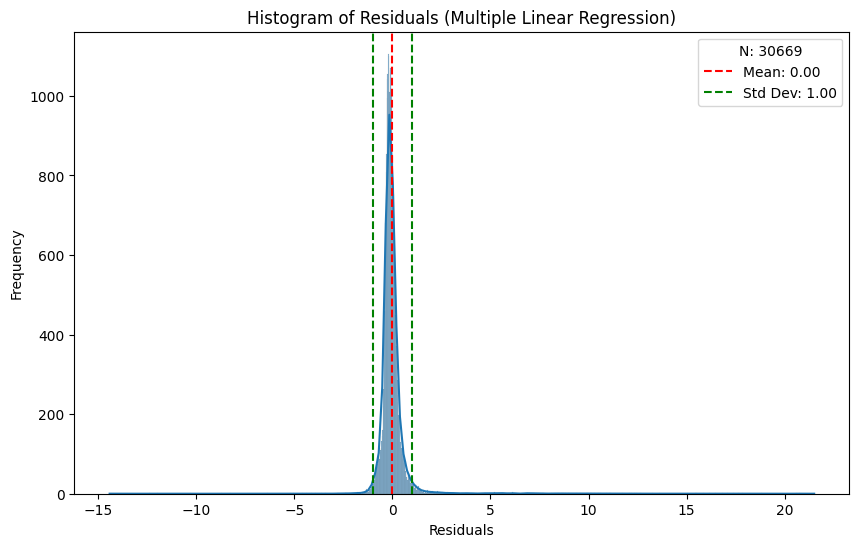

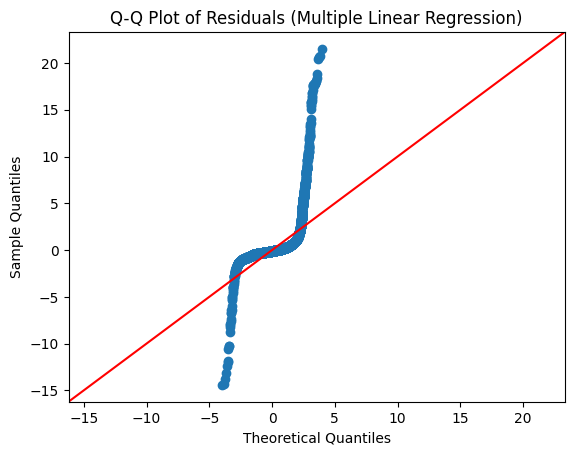

In [341]:
# Tạo mô hình hồi quy tuyến tính bội sử dụng công thức
# Create the formula for the regression model
formula = f"{dependent_var} ~ {' + '.join(independent_vars)}"
# Create the multiple linear regression model using the formula
model_multiple = smf.ols(formula, data=data_model).fit()
print(model_multiple.summary())
print()

# Kiểm định Durbin-Watson
residuals_multiple = model_multiple.resid
durbin_watson_multiple = sm.stats.stattools.durbin_watson(residuals_multiple)

# Redesign the model_summary table
model_summary_multiple = pd.DataFrame({
  'Date': [model_multiple.summary2().tables[0].iloc[2, 1]],
  'Model': ['OLS'],
  'Dependent Variable': [model_multiple.summary2().tables[0].iloc[1, 1]],
  'R-squared': [model_multiple.rsquared],
  'Adj. R-squared': [model_multiple.rsquared_adj],
  'Durbin Watson': [durbin_watson_multiple]
})
print('Model Summary:')
print(model_summary_multiple.to_string(index=False))
print()

# Bảng ANOVA
anova_table_multiple = sm.stats.anova_lm(model_multiple, typ=2, robust='hc3')
# Calculate total sum of squares
total_sum_squares = sum((data_model[dependent_var] - data_model[dependent_var].mean())**2)
# Calculate regression sum of squares
regression_sum_squares = total_sum_squares - anova_table_multiple['sum_sq']['Residual']
# Degrees of freedom
df_regression = model_multiple.summary().tables[0][6][1].data
df_residual = model_multiple.summary().tables[0][7][1].data
df_total = pd.to_numeric(df_regression, errors='coerce') + pd.to_numeric(df_residual, errors='coerce')
# F-statistic and p-value
f_statistic = pd.to_numeric(model_multiple.summary().tables[0][2][3].data, errors='coerce')
p_value = pd.to_numeric(model_multiple.summary().tables[0][3][3].data, errors='coerce')
# Create the ANOVA table
anova_table_multiple = pd.DataFrame({
  'Source': ['Regression', 'Residual', 'Total'],
  'sum_sq': [regression_sum_squares, anova_table_multiple['sum_sq']['Residual'], total_sum_squares],
  'df': [df_regression, df_residual, df_total],
  'F': [f_statistic, None, None],
  'PR(>F)': [p_value, None, None]
})
print('ANOVA Table:')
print(anova_table_multiple.to_string(index=False))
print()

# Bảng Coefficients
coefficients_multiple = model_multiple.summary2().tables[1]
# Calculate the standardized coefficients (beta)
standardized_coefficients = model_multiple.params * (data_model[independent_vars].std() / data_model[dependent_var].std())
# Add the standardized coefficients to the coefficients table
coefficients_multiple['Standardized Coef.'] = standardized_coefficients
# Calculate VIF for each independent variable
vif_data = pd.DataFrame()
vif_data["Variable"] = independent_vars
vif_data["VIF"] = [variance_inflation_factor(data_model[independent_vars].values, i) for i in range(len(independent_vars))]
# Add the VIP column to the coefficients_multiple dataframe
coefficients_multiple = coefficients_multiple.merge(vif_data, how='left', left_index=True, right_on='Variable')
# Rearrange the columns
coefficients_multiple = coefficients_multiple[['Variable', 'Coef.', 'Std.Err.', 'Standardized Coef.', 't', 'P>|t|', '[0.025', '0.975]', 'VIF']]
print('Coefficients:')
print(coefficients_multiple.to_string(index=False))
print()

# Đánh giá Adj. R-squared
adj_r_squared = model_multiple.rsquared_adj
adj_r_squared_result = 'Model fits well' if adj_r_squared > 0.7 else 'Model fits moderate' if 0.5 < adj_r_squared <= 0.7 else 'Model does not fit'
print('Đánh giá Adj. R-squared:')
print(adj_r_squared_result)
print()

# Kiểm định F - Kiểm tra Sig (p-value) bảng ANOVA
anova_p_value = anova_table_multiple.loc[0, 'PR(>F)']
anova_result = 'Model is significant' if anova_p_value < alpha else 'Model is not significant'
print('F Test- Kiểm tra Sig (p-value) bảng ANOVA:')
print(anova_result)
print()

# Kiểm định Durbin–Watson
durbin_watson_result = 'No autocorrelation' if 1.5 < durbin_watson_multiple < 2.5 else 'Autocorrelation present'
print('Durbin–Watson Test:')
print(durbin_watson_result)
print()

# Kiểm định t (student) - Kiểm tra Sig (p-value) từng biến độc lập bảng Coefficients
coefficients_p_values = coefficients_multiple['P>|t|']
# Check the significance of each independent variable excluding 'Intercept'
significant_vars = coefficients_multiple[(coefficients_multiple['P>|t|'] < alpha) & (coefficients_multiple['Variable'] != 'Intercept')]
non_significant_vars = coefficients_multiple[(coefficients_multiple['P>|t|'] >= alpha) & (coefficients_multiple['Variable'] != 'Intercept')]
if significant_vars is None and non_significant_vars is not None:
  result_t_test = f"Non-significant variables: {', '.join(non_significant_vars['Variable'].dropna())}"
elif significant_vars is not None and non_significant_vars is None:
  result_t_test = f"Significant variables: {', '.join(significant_vars['Variable'].dropna())}"
else:
  result_t_test = f"Significant variables: {', '.join(significant_vars['Variable'].dropna())} AND Non-significant variables: {', '.join(non_significant_vars['Variable'].dropna())}"
print('T (student) Test:')
print(result_t_test)
print()

# Check for multicollinearity using VIF
multicollinearity_vars = vif_data[vif_data['VIF'] > 10]
if not multicollinearity_vars.empty:
  multicollinearity_result = "There is a possibility of multicollinearity"
else:
  multicollinearity_result = "The model is suitable as all variables meet the VIF criteria"
print('Đánh giá hiện tượng đa cộng tuyến')
print(multicollinearity_result)
print()

# Predict the values using the regression model
predicted_values = model_multiple.predict(data_model) # Prediction using model_multiple
# Add the predicted values to the dataframe
data_model['predicted_values'] = predicted_values # Adding the column to 'table'
# Calculate MSE using NumPy
mse = np.mean((data_model[dependent_var] - data_model['predicted_values'])**2)
# Calculate RMSE
rmse = np.sqrt(mse)
# Evaluate MSE and RMSE
if mse < 10 : # example threshold, adjust as needed
  mse = f'mse = {mse}. The model\'s Mean Squared Error (MSE) is relatively low, suggesting good fit.'
else:
  mse = f'mse = {mse}. The model\'s Mean Squared Error (MSE) is high, indicating poor fit. Consider model improvement.'
if rmse < 3: # example threshold, adjust as needed
  rmse = f'mse = {rmse}. The model\'s Root Mean Squared Error is relatively low, suggesting accurate predictions.'
else:
  rmse = f'mse = {rmse}. The model\'s Root Mean Squared Error is high, suggesting inaccurate predictions. Consider model improvement.'
print('Đánh giá MSE và RMSE:')
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print()

# Kiểm tra nếu có điểm nào không đạt yêu cầu
if adj_r_squared_result != 'Model fits well' or anova_result != 'Model is significant' or durbin_watson_result != 'No autocorrelation' or multicollinearity_result != 'The model is suitable as all variables meet the VIF criteria' or 'Non-significant variables' in result_t_test:
  conclusion = "Should Optimized Model"
else:
  conclusion = "Model Meets Requirements"
print('Đánh giá tổng hợp:')
print(conclusion)
print()

# Tạo bảng hypothesis_test
hypothesis_test = pd.DataFrame({
  'Đánh giá Adj. R-squared': [f'Adjusted R-squared: {adj_r_squared:.3f}, Result: {adj_r_squared_result}'],
  'F Test': [f'ANOVA p-value: {anova_p_value:.3e}, Result: {anova_result}'],
  'T (student) Test': [result_t_test],
  'Durbin-Watson Test': [f'Durbin-Watson: {durbin_watson_multiple:.3f}, Result: {durbin_watson_result}'],
  'VIP Test': [multicollinearity_result],
  'mse': [mse],
  'rmse': [rmse],
  'Conclusion': [conclusion]
})
hypothesis_test = hypothesis_test.melt(var_name='Test', value_name='Result')

# Viết phương trình hồi quy
intercept = coefficients_multiple.loc[coefficients_multiple['Variable'] == 'Intercept', 'Coef.'].values[0]
slopes = coefficients_multiple.loc[coefficients_multiple['Variable'] != 'Intercept', ['Variable', 'Coef.']]
regression_equation = f'y = {intercept:.2f}'
for index, row in slopes.iterrows():
  regression_equation += f' + {row["Coef."]:.2f} * {row["Variable"]}'
  regression_equation = f'y = {intercept:.2f}'
  for index, row in slopes.iterrows():
    coef = row["Coef."]
    variable = row["Variable"]
    sign = '+' if coef >= 0 else '-'
    regression_equation += f' {sign} {abs(coef):.3f} * {variable}'
print('Regression Equation:')
print(regression_equation)
print()

# Tạo bảng phương trình hồi quy
regression_equation_df = pd.DataFrame({
  'Function': [regression_equation],
  'Conclusion': [conclusion]
})

# Biểu đồ Histogram để khảo sát phân phối của phần dư
standardized_residuals_multiple = model_multiple.get_influence().resid_studentized_internal
mean_residuals_multiple = standardized_residuals_multiple.mean()
std_dev_residuals_multiple = standardized_residuals_multiple.std()
N_residuals_multiple = len(standardized_residuals_multiple)
plt.figure(figsize=(10, 6))
sns.histplot(standardized_residuals_multiple, kde=True)
plt.title('Histogram of Residuals (Multiple Linear Regression)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.axvline(mean_residuals_multiple, color='r', linestyle='--', label=f'Mean: {mean_residuals_multiple:.2f}')
plt.axvline(mean_residuals_multiple + std_dev_residuals_multiple, color='g', linestyle='--', label=f'Std Dev: {std_dev_residuals_multiple:.2f}')
plt.axvline(mean_residuals_multiple - std_dev_residuals_multiple, color='g', linestyle='--')
plt.legend(title=f'N: {N_residuals_multiple}')
plt.show()
print()

# Biểu đồ Q-Q plot để khảo sát phân phối của phần dư
sm.qqplot(standardized_residuals_multiple, line='45')
plt.title('Q-Q Plot of Residuals (Multiple Linear Regression)')
plt.show()

# 6 PREDICTION

In [342]:
# Predict the values using the regression model
predicted_values = model_multiple.predict(data_model)

# Add the predicted values to the dataframe
data_model['predicted_values'] = predicted_values

# Get the column names of independent variables from the model
independent_vars = list(model_multiple.params.index)
independent_vars.remove('Intercept')

# Construct the column list for display, dynamically adding independent variable names
columns_to_display = ['predicted_values'] + independent_vars
data_model[columns_to_display]
print(data_model.head(100))

      fare  trip_miles  trip_seconds  tip_rate  company  predicted_values
0    31.99        2.57          2341       6.3       14         14.848010
1     9.75        1.18          1074      27.9       14          8.622288
2    10.25        1.29          1173       0.0       24          9.420452
3    23.75        3.70          3360       0.0       12         19.702532
4    10.00        1.15          1044       0.0       14          9.042955
5    11.00        1.38          1251      27.3       14          9.456005
6    14.50        2.00          1813       0.0       24         12.365352
7    14.75        2.05          1857      25.8       24         12.059735
8     8.00        0.87           787       0.0       13          7.891750
9    17.88        1.55          1399      23.0       14         10.233903
11    6.50        0.60           540       0.0       25          6.511639
12    7.50        0.80           720      26.7       29          6.728321
13    7.50        0.80           720  

# 7 CONCLUSION

In [343]:
standardized_coefficients_sorted = standardized_coefficients.sort_values(key=abs,ascending=False)
standardized_coefficients_sorted

,0
trip_miles,0.877336
trip_seconds,0.126455
tip_rate,-0.015371
company,-0.008807
Intercept,NaN


The order of factors with the strongest impact on the model:
1. trip_miles
2. trip_seconds
3. tip_rate
4. company

Top 6 company:
- Flash Cab
- Taxi Affiliation Services
- Sun Taxi
- City Service
- Chicago Independents
- Medallion Leasin

In [344]:
# input data
company = 'Flash Cab'

company_value = mapping_company[mapping_company['Original'] == company]['Encoded'].iloc[0]

# Define the value of independent variables for which you want to predict the dependent variable
new_data = pd.DataFrame({'trip_miles': [60],
                         'trip_seconds': [3000],
                         'tip_rate': [30],
                         'company': [company_value]
                         })

# Predict the dependent variable value using the regression model
predicted_sales = model_multiple.predict(new_data)
# Display the predicted value
print(f'Predicted {dependent_var} for {independent_vars}: {predicted_sales.iloc[0]}')


Predicted fare for ['trip_miles', 'trip_seconds', 'tip_rate', 'company']: 132.59972424979156
